# Skymaps (with distance) for high confidence GTWC events

In [28]:
from ligo.skymap.io.fits import read_sky_map
from astropy.io import fits
import matplotlib.pyplot as plt
import healpy as hp
import numpy as np
from healpy.newvisufunc import projview, newprojplot
#custom cmap
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import matplotlib.colors as colors
import glob
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

cmap = plt.get_cmap('jet')
cmap = truncate_colormap(cmap, 0.24, 1)
tmp = cmap
newcolors = tmp(np.linspace(0, 1, 256))
white = np.array([1,1,1, 1])
newcolors[:2, :] = white
newcmp = ListedColormap(newcolors)
cmap = newcmp

# We have three Releases: GWTC-1, 2p1, 3. 
### (https://www.gw-openscience.org/eventapi/html/GWTC/)
### GWTC-1 Seems to be part of 2p1, except for 170817 (https://www.gw-openscience.org/events/GW170817/)
### Also there are a few files that should not be in the 'confident' release but are there
### Lastly, some events have a 'low-spin', 'high-spin' degeneracy


In [241]:
GWTC1_files = sorted(glob.glob("./GWTC-1_skymaps/*"))
GWTC2_files = sorted(glob.glob("./GWTC-2p1_skymaps/*Mixed.fits")) #first 10 are identical to GTWC-1
GWTC3_files = sorted(glob.glob("./GWTC-3_skymaps/*Mixed.fits"))



In [242]:
print("Number of files in GWTC-1: ", len(GWTC1_files) )
print("Number of files in GWTC-2: ", len(GWTC2_files) )
print("Number of files in GWTC-3: ", len(GWTC3_files) )

Number of files in GWTC-1:  11
Number of files in GWTC-2:  51
Number of files in GWTC-3:  36


#### Downsize the pixel maps from 256 to 32


In [231]:
nside_small = 32
npix = hp.nside2npix(nside_small)
pix_indices = np.arange(npix)
ra,dec = hp.pix2ang(nside_small, pix_indices, lonlat=True)

#### Prepare dict array for Name, Distmean, Diststd, Probability Array (Size 12288: 32**2*12)

In [227]:
my_dtype = np.dtype([
    ('name', 'U50'),  # String field with a maximum length of 50 characters
    ('distmean', 'f8'),  # Float field for the mean distance
    ('distvar', 'f8'),  # Float field for the distance variance
    ('probability', 'f8', (12288))  # 3x3 numpy array field
])

#### Loop over GWTC-1 and fill the dict array

In [234]:
dict_arr = np.empty(0, dtype=my_dtype)

for i in GWTC1_files:
    prob, header  =  read_sky_map(i)
    title = str(i.split("/")[2]).split("_")[0]
    prob_small = hp.ud_grade(prob, nside_small)
    prob_small/=prob_small.sum()
    arr_dict = np.array([  (title, header["distmean"], header["diststd"], prob_small ) ], dtype=my_dtype)
    dict_arr = np.append(dict_arr, arr_dict)

#### Repeat with GWTC-2p1 and GWTC-3
#### The first 10 entries of GWTC-2p1 are dublicates of GWTC-1 

In [243]:
for i in GWTC2_files[10:]:
    prob, header  =  read_sky_map(i)
    title = i.split("-")[-1].split("_")[0]
    prob_small = hp.ud_grade(prob, nside_small)
    prob_small/=prob_small.sum()
    arr_dict = np.array([  (title, header["distmean"], header["diststd"], prob_small ) ], dtype=my_dtype)
    dict_arr = np.append(dict_arr, arr_dict)


In [244]:
for i in GWTC3_files:
    prob, header  =  read_sky_map(i)
    title = i.split("-")[-1].split("_")[0]
    prob_small = hp.ud_grade(prob, nside_small)
    prob_small/=prob_small.sum()
    arr_dict = np.array([  (title, header["distmean"], header["diststd"], prob_small ) ], dtype=my_dtype)
    dict_arr = np.append(dict_arr, arr_dict)

#### Test

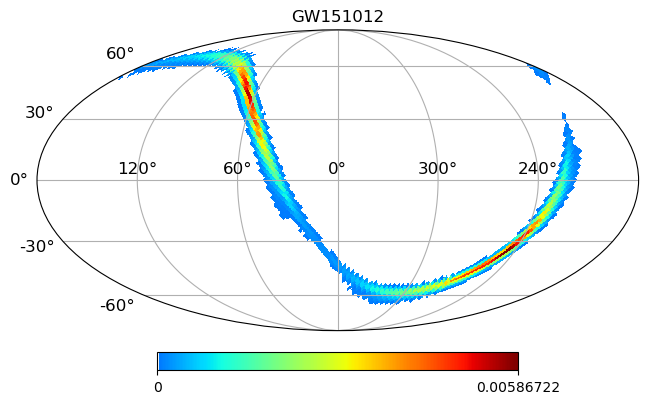

In [248]:
map=projview( dict_arr["probability"][1],  graticule=True, graticule_labels=True, title=title,projection_type="mollweide",cmap=cmap,hold=True)
plt.title(dict_arr["name"][1])
plt.show()

#### Save and end

In [249]:
np.save('GW_skymaps.npy',dict_arr)